# Introduction
Data is drawn from the [Boston Property Assessment Dataset](https://data.boston.gov/dataset/property-assessment), which also provides a data key.

Because of the large size of the dataset, only residential properties were used when fitting models.

In [1]:
# libraries and settings
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from fbprophet import Prophet
# suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# display settings
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

ModuleNotFoundError: No module named 'fbprophet'

In [6]:
# read dtype and specification table from Excel
propDtypes = pd.read_excel('prop_dtypes.xlsx', index_col='col')
# fill na values in boolean cols
bool_cols = ['is_luxury', 'always_drop', 'commercial_only']
propDtypes[bool_cols] = propDtypes[bool_cols].fillna(False).astype('bool')
display(propDtypes.head(10))
# convert into dictionary for use with read_csv
dtDict = propDtypes['dtype'].to_dict()

,dtype,is_luxury,always_drop,commercial_only,value_dict,comment
col,,,,,,
PID,int64,False,False,False,NaN,NaN
CM_ID,float64,False,True,False,NaN,only useful when looking at units inside a giv...
GIS_ID,int64,False,True,False,NaN,NaN
ST_NUM,str,False,True,False,NaN,NaN
ST_NAME,str,False,True,False,NaN,NaN
ST_NAME_SUF,str,False,True,False,NaN,NaN
UNIT_NUM,str,False,True,False,NaN,NaN
ZIPCODE,str,False,False,False,NaN,NaN
PTYPE,int64,False,True,False,NaN,NaN


In [7]:
# read raw data, allow implicit type detection even though you provide types
prop = pd.read_csv('fy19fullpropassess.csv', low_memory=False,
                  dtype=dtDict)

In [8]:
# load Boston zip codes to map neighborhoods
zipNbh = pd.read_excel('zipNeighborhoods.xlsx',
                       converters={'zip': str, 'Neighborhood': str})
zipNbh.set_index('zip', inplace=True)

# Exploratory Analysis

In [9]:
# show samples of property and zipcode data
print('Example Property Data:')
display(prop.sample(10))
print('Example Zipcode Data:')
display(zipNbh.sample(10))

Example Property Data:


,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,OWN_OCC,OWNER,MAIL_ADDRESSEE,MAIL_ADDRESS,MAIL CS,MAIL_ZIPCODE,AV_LAND,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,YR_BUILT,YR_REMOD,GROSS_AREA,LIVING_AREA,NUM_FLOORS,STRUCTURE_CLASS,R_BLDG_STYL,R_ROOF_TYP,R_EXT_FIN,R_TOTAL_RMS,R_BDRMS,R_FULL_BTH,R_HALF_BTH,R_BTH_STYLE,R_BTH_STYLE2,R_BTH_STYLE3,R_KITCH,R_KITCH_STYLE,R_KITCH_STYLE2,R_KITCH_STYLE3,R_HEAT_TYP,R_AC,R_FPLACE,R_EXT_CND,R_OVRALL_CND,R_INT_CND,R_INT_FIN,R_VIEW,S_NUM_BLDG,S_BLDG_STYL,S_UNIT_RES,S_UNIT_COM,S_UNIT_RC,S_EXT_FIN,S_EXT_CND,U_BASE_FLOOR,U_NUM_PARK,U_CORNER,U_ORIENT,U_TOT_RMS,U_BDRMS,U_FULL_BTH,U_HALF_BTH,U_BTH_STYLE,U_BTH_STYLE2,U_BTH_STYLE3,U_KITCH_TYPE,U_KITCH_STYLE,U_HEAT_TYP,U_AC,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW
62881,603801063,6.038010e+08,603801010,766 - 780,E THIRD,ST,NaN,2127,108,CP,N,LYNCH JOHN B IV,C/O JOHN B LYNCH IV,770 E THIRD ST #3,S BOSTON MA,2127,0,28000,28000,29512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156354,2011149000,NaN,2011149000,,PINE,RD,NaN,2132,902,E,N,CITY OF BOSTON,,PINE RD,WEST ROXBURY MA,2132,15200,0,15200,0,3412.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84176,1101935034,1.101935e+09,1101935020,8,BRINTON,ST,1,2119,102,CD,Y,DEVEAUX LILIANA,,8 BRINTON ST #1,ROXBURY MA,2119,0,259400,259400,273408,1444.0,2006.0,NaN,1444.0,1444.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,N,T,6,3.0,1.0,1.0,M,M,NaN,O,M,F,C,0.0,N,G,A
41245,501147000,NaN,501147000,147 153,COLUMBUS,AV,NaN,2116,347,C,N,BERKELEY/COLUMBUS REAL,C/O JOANNE BRAGS DIR,175 BERKELEY ST,BOSTON MA,2116,8643235,23232957,31876192,79690480,6002.0,2010.0,NaN,1.0,1.0,1.0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10635,200973000,NaN,200973000,15,EDEN,ST,NaN,2129,104,R2,Y,MORRISSEY MARY J,,15 EDEN ST,CHARLESTOWN MA,2129,230100,524400,754500,795243,2808.0,1880.0,0.0,3948.0,2956.0,3.0,R,RE,F,B,9.0,4.0,2.0,0.0,N,N,NaN,2.0,N,N,NaN,F,N,0.0,A,A,F,N,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94519,1302923000,NaN,1302923000,58,SAGAMORE,ST,NaN,2125,104,R2,Y,POWELL V LUCIOUS,,58 SAGAMORE ST,DORCHESTER MA,2125,196200,463700,659900,695535,5105.0,1900.0,0.0,6155.0,3621.0,2.5,R,CV,G,P,12.0,4.0,2.0,0.0,M,M,NaN,2.0,M,M,NaN,W,N,0.0,A,A,A,N,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20044,302271014,3.022710e+08,302271000,160,SALEM,ST,7,2113,102,CD,N,NEWE LLC,,142 MARLBOROUGH ST,BOSTON MA,2116,0,525200,525200,553561,798.0,1910.0,1984.0,798.0,798.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,N,F,3,1.0,1.0,0.0,M,NaN,NaN,O,M,W,N,0.0,N,G,A
7887,106333000,NaN,106333000,221,CHELSEA,ST,NaN,2128,105,R3,N,LICCIARDI FRANK A,C/O FRANK LICCIARDI,8 PLYMOUTH ST,N READING MA,1864,155300,516900,672200,708499,2000.0,1910.0,2006.0,4325.0,2885.0,3.0,R,DK,F,M,14.0,8.0,3.0,0.0,M,M,M,3.0,M,M,M,W,N,0.0,A,G,G,N,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168128,2201269002,2.201269e+09,2201269000,17 19,ALDIE,ST,1,2134,102,CD,N,CHANG STEPHEN T,,17 19 ALDIE ST #1,ALLSTON MA,2134,0,367700,367700,387556,938.0,1890.0,2005.0,938.0,938.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,N,T,5,2.0,1.0,0.0,M,NaN,NaN,F,M,F,N,0.0,N,G,A
10538

Example Zipcode Data:


,Neighborhood
zip,
02109,Boston North End
02115,Boston Fenway
02135,Brighton
02132,West Roxbury
02110,Boston Downtown Crossing
02467,Brookline
02111,Boston Chinatown
02120,Roxbury Mission Hill
02136,Hyde Park


# Cleanup and Transformation

In [10]:
# drop columns that aren't going to be used in this analysis
dropCols = list(propDtypes.loc[propDtypes['always_drop'] | propDtypes['commercial_only']].index)
print('columns to be dropped:')
display(dropCols)
prop = prop.drop(columns=list(dropCols), axis=1)
display(prop.sample(5))

columns to be dropped:


['CM_ID',
 'GIS_ID',
 'ST_NUM',
 'ST_NAME',
 'ST_NAME_SUF',
 'UNIT_NUM',
 'PTYPE',
 'MAIL_ADDRESSEE',
 'MAIL_ADDRESS',
 'MAIL CS',
 'MAIL_ZIPCODE',
 'GROSS_AREA',
 'STRUCTURE_CLASS']

,PID,ZIPCODE,LU,OWN_OCC,OWNER,AV_LAND,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,YR_BUILT,YR_REMOD,LIVING_AREA,NUM_FLOORS,R_BLDG_STYL,R_ROOF_TYP,R_EXT_FIN,R_TOTAL_RMS,R_BDRMS,R_FULL_BTH,R_HALF_BTH,R_BTH_STYLE,R_BTH_STYLE2,R_BTH_STYLE3,R_KITCH,R_KITCH_STYLE,R_KITCH_STYLE2,R_KITCH_STYLE3,R_HEAT_TYP,R_AC,R_FPLACE,R_EXT_CND,R_OVRALL_CND,R_INT_CND,R_INT_FIN,R_VIEW,S_NUM_BLDG,S_BLDG_STYL,S_UNIT_RES,S_UNIT_COM,S_UNIT_RC,S_EXT_FIN,S_EXT_CND,U_BASE_FLOOR,U_NUM_PARK,U_CORNER,U_ORIENT,U_TOT_RMS,U_BDRMS,U_FULL_BTH,U_HALF_BTH,U_BTH_STYLE,U_BTH_STYLE2,U_BTH_STYLE3,U_KITCH_TYPE,U_KITCH_STYLE,U_HEAT_TYP,U_AC,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW
170400,2203022000,2135,R2,Y,MARIANO DANIEL M,188600,654800,843400,888944,4790.0,1900.0,0.0,3446.0,2.0,CV,H,M,15.0,4.0,2.0,0.0,S,N,NaN,2.0,S,N,NaN,W,N,0.0,A,A,A,N,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110823,1604437000,2124,R1,Y,OBRIEN PAUL R ETAL,143200,377900,521100,549240,3750.0,1925.0,2011.0,1674.0,2.0,CL,G,M,7.0,3.0,1.0,1.0,S,S,NaN,1.0,S,NaN,NaN,W,C,1.0,A,A,A,N,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78340,1000202000,2115,A,N,RTH COOP HOUSING LLC,162933,152301,315234,332257,3780.0,1920.0,0.0,4330.0,2.5,TF,G,W,15.0,9.0,2.0,0.0,N,N,NaN,2.0,N,N,NaN,W,N,0.0,A,A,A,N,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9895,200542028,2129,CD,Y,VARGAS JORGE H,0,467300,467300,492534,1025.0,1920.0,1986.0,1025.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,N,T,5,3.0,1.0,0.0,S,NaN,NaN,O,S,E,N,0.0,N,A,A
144335,2001719000,2132,R1,Y,MORSE MERRY L,256100,478400,734500,774163,8050.0,1910.0,1999.0,2385.0,2.0,CL,G,W,7.0,4.0,1.0,1.0,M,S,NaN,1.0,S,NaN,NaN,F,C,2.0,A,A,A,N,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# fix zip codes by prepending zero
shortFlag = prop['ZIPCODE'].str.len()==4
shortZips = prop.loc[shortFlag, 'ZIPCODE']
prop.loc[shortFlag, 'ZIPCODE'] = '0' + shortZips
print('zip codes after prepending leading zero:')
display(prop['ZIPCODE'].head(10))
display(prop.sample(3))

zip codes after prepending leading zero:


0    02108
1    02108
2    02108
3    02108
4    02108
5    02108
6    02108
7    02108
8    02108
9    02108
Name: ZIPCODE, dtype: object

,PID,ZIPCODE,LU,OWN_OCC,OWNER,AV_LAND,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,YR_BUILT,YR_REMOD,LIVING_AREA,NUM_FLOORS,R_BLDG_STYL,R_ROOF_TYP,R_EXT_FIN,R_TOTAL_RMS,R_BDRMS,R_FULL_BTH,R_HALF_BTH,R_BTH_STYLE,R_BTH_STYLE2,R_BTH_STYLE3,R_KITCH,R_KITCH_STYLE,R_KITCH_STYLE2,R_KITCH_STYLE3,R_HEAT_TYP,R_AC,R_FPLACE,R_EXT_CND,R_OVRALL_CND,R_INT_CND,R_INT_FIN,R_VIEW,S_NUM_BLDG,S_BLDG_STYL,S_UNIT_RES,S_UNIT_COM,S_UNIT_RC,S_EXT_FIN,S_EXT_CND,U_BASE_FLOOR,U_NUM_PARK,U_CORNER,U_ORIENT,U_TOT_RMS,U_BDRMS,U_FULL_BTH,U_HALF_BTH,U_BTH_STYLE,U_BTH_STYLE2,U_BTH_STYLE3,U_KITCH_TYPE,U_KITCH_STYLE,U_HEAT_TYP,U_AC,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW
34742,400888008,02115,CD,N,ROCHA GISELA,0,1078900,1078900,1137161,1276.0,1890.0,2017.0,1276.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,N,T,5,2.0,1.0,1.0,M,M,NaN,F,M,W,N,2.0,N,G,A
126882,1807634008,02136,R1,Y,YOUNG SHARMAIN,103300,208200,311500,328321,3250.0,1956.0,0.0,1306.0,1.5,CP,G,M,6.0,4.0,2.0,0.0,S,S,NaN,1.0,S,NaN,NaN,W,N,1.0,A,A,A,N,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23351,303135096,02113,CP,N,AMENO GENNARO,0,56000,56000,59024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# count number of luxury features
luxCols = list(propDtypes.loc[propDtypes['is_luxury']].index)
print('style fields that indicate the presence of luxury finishes:')
luxVals = prop[luxCols]
display(luxVals.head(10))
# Count number of "L" values
isLux = luxVals == 'L'
nLux = isLux.sum(axis=1)
print('# of luxury finished rooms:')
display(nLux.head(10))
prop['n_lux'] = nLux

style fields that indicate the presence of luxury finishes:


,R_BTH_STYLE,R_BTH_STYLE2,R_BTH_STYLE3,R_KITCH_STYLE,R_KITCH_STYLE2,R_KITCH_STYLE3,U_BTH_STYLE,U_BTH_STYLE2,U_BTH_STYLE3,U_KITCH_STYLE
0,NaN,NaN,NaN,NaN,NaN,NaN,M,M,NaN,M
1,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,S
2,NaN,NaN,NaN,NaN,NaN,NaN,M,S,NaN,M
3,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,N
4,NaN,NaN,NaN,NaN,NaN,NaN,L,M,M,L
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,S
7,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN,M
8,NaN,NaN,NaN,NaN,NaN,NaN,L,L,L,L
9,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN,M


# of luxury finished rooms:


0    0
1    0
2    0
3    0
4    2
5    0
6    0
7    0
8    4
9    0
dtype: int64

In [13]:
# merge zipcodes with neighborhood, which appears as last column
prop = pd.merge(prop, zipNbh, left_on='ZIPCODE', right_index=True, how='left')
display(prop['Neighborhood'].sample(5))

16317       Boston West End
105199           Dorchester
157864       Boston Kenmore
85320         Jamaica Plain
111147    Dorchester Center
Name: Neighborhood, dtype: object

In [14]:
# show total properties by neighborhood
allCnts = prop['Neighborhood'].value_counts()
display(allCnts)

South Boston                14312
Jamaica Plain               11688
Brighton                    11517
Dorchester Center           10964
West Roxbury                10936
Boston Back Bay              9392
Hyde Park                    9230
Roslindale                   8987
East Boston                  8722
Boston South End             8706
Dorchester Uphams Corner     7580
Charlestown                  7171
Roxbury                      6091
Dorchester                   6091
Boston Fenway                5209
Boston West End              5209
Mattapan                     4936
Allston                      4437
Dorchester Grove Hall        4304
Boston North End             4201
Boston Kenmore               3578
Boston Chinatown             2859
Boston Downtown Crossing     2152
Boston Beacon  Hill          2130
Roxbury Mission Hill         1891
Boston                       1305
Brookline                    1055
Name: Neighborhood, dtype: int64

In [15]:
# filter to residential properties
# residential land use codes from data dictionary
# exclude condo main entries, only want condos themselves
resi_lu_codes = ['A','CD','R1','R2','R3','R4','RC','RL']
# create a copy of underlying df just in case
resi = prop.loc[prop['LU'].isin(resi_lu_codes)].copy()
# residential count by nbhd
resiCnts = resi['Neighborhood'].value_counts()


In [16]:
compDf = pd.concat([allCnts.to_frame(), resiCnts.to_frame()], axis=1)
compDf.columns = ['all', 'residential']
compDf.loc['TOTAL CITY', :] = [allCnts.sum(), resiCnts.sum()]
compDf['Pct_Residential'] = compDf['residential'] / compDf['all']
compDf = compDf.sort_values('Pct_Residential', ascending=False)
display(compDf)

,all,residential,Pct_Residential
Brookline,1055.0,1027.0,0.973460
West Roxbury,10936.0,9855.0,0.901152
Brighton,11517.0,10269.0,0.891638
Hyde Park,9230.0,8137.0,0.881582
Dorchester Center,10964.0,9590.0,0.874681
Roslindale,8987.0,7799.0,0.867809
Allston,4437.0,3821.0,0.861167
Mattapan,4936.0,4241.0,0.859198
Dorchester Grove Hall,4304.0,3648.0,0.847584
Dorchester,6091.0,5057.0,0.830241


Brookline and West Roxbury are the most residential neighborhoods in Boston.

# Predicting Condo Values: More Data Prep


In [17]:
# filter to just condo units for regressions
condos = resi.loc[resi['LU'] == 'CD']
print('# of condos by neighborhood:')
condos['Neighborhood'].value_counts()

# of condos by neighborhood:


South Boston                6732
Boston Back Bay             6531
Brighton                    5826
Boston South End            4886
Jamaica Plain               4805
Charlestown                 3469
Boston West End             3076
Boston Fenway               3039
Boston North End            2533
Boston Kenmore              2369
Allston                     2092
Dorchester Uphams Corner    1856
East Boston                 1837
Boston Chinatown            1822
Roslindale                  1785
Boston Downtown Crossing    1528
Dorchester                  1472
Dorchester Center           1465
West Roxbury                1221
Boston Beacon  Hill         1102
Roxbury                      983
Brookline                    848
Hyde Park                    787
Boston                       757
Roxbury Mission Hill         436
Dorchester Grove Hall        384
Mattapan                     269
Name: Neighborhood, dtype: int64

In [18]:
# get latest construction year for each condo property (new or remodel)
# fill in empty remodels with year built so that there are no NaN values
condos.loc[(condos['YR_REMOD'] == 0), 'YR_REMOD'] = np.nan
condos['YR_REMOD'].fillna(condos['YR_BUILT'], inplace=True)
# in case year built was also 0, flag as nan again
condos.loc[(condos['YR_REMOD'] == 0), 'YR_REMOD'] = np.nan
condos = condos.loc[~condos['YR_REMOD'].isnull()]
display(condos['YR_REMOD'].describe())

count    63853.000000
mean      1991.380045
std         23.822814
min       1500.000000
25%       1984.000000
50%       1997.000000
75%       2006.000000
max       2018.000000
Name: YR_REMOD, dtype: float64

In [19]:
# calculate years since remodel
condos['age'] = dt.datetime.now().year - condos['YR_REMOD']
display(condos['age'].describe())

count    63853.000000
mean        27.619955
std         23.822814
min          1.000000
25%         13.000000
50%         22.000000
75%         35.000000
max        519.000000
Name: age, dtype: float64

In [20]:
# filter to condos with age <= 250 years to reduce the effect of age outliers
condos = condos.loc[condos['age'] <= 250]

count       63852
mean       678048
std        732730
min         41700
25%        344600
50%        488500
75%        723425
max      34057908
Name: AV_TOTAL, dtype: int32

Text(0, 0.5, 'Count')

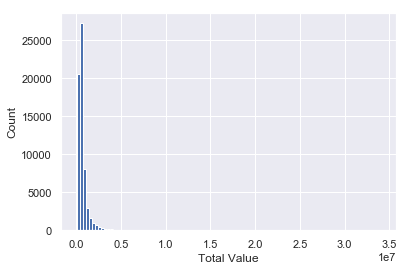

In [21]:
# examine total assessed value distribution
display(condos['AV_TOTAL'].describe().astype(int))
fig = plt.hist(condos['AV_TOTAL'], bins=100)
plt.xlabel('Total Value')
plt.ylabel('Count')

In [22]:
# figure out what percentile to cut
pctls = [0.8, 0.85, 0.9, 0.95, 0.975, 0.9825, 0.99]
display(pd.Series({k: v for k, v in zip(pctls, condos['AV_TOTAL'].quantile(pctls))}))

0.8000     809500.00
0.8500     946200.00
0.9000    1215680.00
0.9500    1789045.00
0.9750    2491200.00
0.9825    2919144.69
0.9900    3717579.00
dtype: float64

The histogram above shows that the distribution of condo values is highly right-skewed-- to limit the impact this has on our regressions, we must exclude some outliers.

Based on the percentiles above, I have chosen to limit the condos in the sample to the 90th percentile of values.

In [23]:
cutPctl = 0.9
# create prediction df
pred = condos.copy()
pred = pred.loc[pred['AV_TOTAL'] <= pred['AV_TOTAL'].quantile(cutPctl)]

In [24]:
# force number of rooms to be numeric
pred['U_TOT_RMS'] = pred['U_TOT_RMS'].astype(float, errors='ignore')

# Zip Code Demographic Data

In [25]:
# merge with zipcode data
import uszipcode
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=False)
# search = SearchEngine()
# identify columns of interest from full us zip code dataset
zipCols = ['population', 'population_density', 'land_area_in_sqmi', 'water_area_in_sqmi', 
           'housing_units', 'occupied_housing_units', 'median_home_value', 'median_household_income']

In [26]:
# extract unique zips and look up
unqZips = pred['ZIPCODE'].unique()
# display(unqZips)
zipData = {}
for zc in unqZips:
    zd = search.by_zipcode(zc)   
    # too many fields, with nested sub-fields...    
    zd = zd.to_dict()
    # filter to the columns that we want    
    zf = {}
    # copy keys that don't need modification over
    for zk in zipCols:
        zf[zk] = zd[zk]    
    # manually extract earnings status
    es = zd['employment_status'][0]['values']
    d = pd.DataFrame.from_records(es)    
    d.set_index('x', inplace=True)    
    # TODO: clean up subscripting/parens here
    zf['pct_employed'] = ((d.loc['Worked Full-time With Earnings'] + d.loc['Worked Part-time With Earnings']) / d['y'].sum()).values[0]
    # calculate percentage of owner-occupied
    zf['pct_occupied'] = (zf['occupied_housing_units'] / zf['housing_units'])
    # manually extract population below 30 and above 65
    pa = zd['population_by_age'][0]['values']
    d = pd.DataFrame.from_records(pa)    
    d.set_index('x', inplace=True) 
    zf['pct_under30'] = (d.loc[:'25-29'].sum() / d['y'].sum()).values[0]
    zf['pct_over65'] = (d.loc['65-69':].sum() / d['y'].sum()).values[0]
    # manually extract population with kids
    pk = zd['households_with_kids'][0]['values']
    d = pd.DataFrame.from_records(pk)    
    d.set_index('x', inplace=True)    
    zf['pct_with_kids'] = d.loc['Households With Kids'].sum() / d['y'].sum()
    # extract percent white
    p = zd['population_by_race'][0]['values']
    d = pd.DataFrame.from_records(p)    
    d.set_index('x', inplace=True)    
    zf['pct_white'] = d['y'].loc['White'] / d['y'].sum()
    # extract percent rich (hhi > 200k)
    p = zd['household_income'][0]['values']
    d = pd.DataFrame.from_records(p)    
    d.set_index('x', inplace=True)    
    zf['pct_rich'] = d['y'].loc['$200,000+'] / d['y'].sum()
    # save filtered/extracted dictionary
    zipData[zc] = zf

# build zip code dataframe
zdf = pd.DataFrame.from_dict(zipData, orient='index')
print('example zip code statistics to be merged with property data:')
display(zdf.sample(5))

example zip code statistics to be merged with property data:


,population,population_density,land_area_in_sqmi,water_area_in_sqmi,housing_units,occupied_housing_units,median_home_value,median_household_income,pct_employed,pct_occupied,pct_under30,pct_over65,pct_with_kids,pct_white,pct_rich
02118,26498,24075.0,1.10,0.01,12967,12314,561100,54152,0.711943,0.949641,0.387396,0.079758,0.171350,0.538003,0.126882
02121,25978,14884.0,1.75,0.01,10589,9661,311700,28238,0.581737,0.912362,0.542892,0.072654,0.439188,0.075872,0.011474
02122,23479,11554.0,2.03,0.63,8887,8066,320900,50192,0.658695,0.907618,0.439284,0.081441,0.377882,0.373355,0.017333
02109,3771,21721.0,0.17,0.11,2462,2028,676700,119196,0.757970,0.823721,0.343414,0.131215,0.076430,0.880403,0.251261
02120,15181,24456.0,0.62,0.00,5335,5057,272900,35077,0.714752,0.947891,0.726093,0.045339,0.235515,0.502865,0.026611


In [27]:
# merge zipcodes data with other predictors
pred = pd.merge(pred, zdf, left_on='ZIPCODE', right_index=True, how='left')
display(pred.sample(10))

,PID,ZIPCODE,LU,OWN_OCC,OWNER,AV_LAND,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,YR_BUILT,YR_REMOD,LIVING_AREA,NUM_FLOORS,R_BLDG_STYL,R_ROOF_TYP,R_EXT_FIN,R_TOTAL_RMS,R_BDRMS,R_FULL_BTH,R_HALF_BTH,R_BTH_STYLE,R_BTH_STYLE2,R_BTH_STYLE3,R_KITCH,R_KITCH_STYLE,R_KITCH_STYLE2,R_KITCH_STYLE3,R_HEAT_TYP,R_AC,R_FPLACE,R_EXT_CND,R_OVRALL_CND,R_INT_CND,R_INT_FIN,R_VIEW,S_NUM_BLDG,S_BLDG_STYL,S_UNIT_RES,S_UNIT_COM,S_UNIT_RC,S_EXT_FIN,S_EXT_CND,U_BASE_FLOOR,U_NUM_PARK,U_CORNER,U_ORIENT,U_TOT_RMS,U_BDRMS,U_FULL_BTH,U_HALF_BTH,U_BTH_STYLE,U_BTH_STYLE2,U_BTH_STYLE3,U_KITCH_TYPE,U_KITCH_STYLE,U_HEAT_TYP,U_AC,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW,n_lux,Neighborhood,age,population,population_density,land_area_in_sqmi,water_area_in_sqmi,housing_units,occupied_housing_units,median_home_value,median_household_income,pct_employed,pct_occupied,pct_under30,pct_over65,pct_with_kids,pct_white,pct_rich
104002,1502726012,02125,CD,Y,JONES SONIA,0,210200,210200,221551,755.0,1970.0,2005.0,755.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,N,T,5,3.0,1.0,0.0,S,NaN,NaN,F,S,F,N,0.0,N,A,A,0,Dorchester Uphams Corner,14.0,33295,15611.0,2.13,0.31,13263,12151,301200,45130,0.669499,0.916158,0.494055,0.073175,0.332483,0.345637,0.028621
50382,503596006,02115,CD,Y,OHARA NEIL,0,733600,733600,773215,873.0,1989.0,1989.0,873.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,N,T,3,1.0,1.0,0.0,S,NaN,NaN,O,S,W,C,0.0,N,G,A,0,Boston Fenway,30.0,28441,40159.0,0.71,0.04,10838,10384,611800,27134,0.722981,0.958110,0.730003,0.060497,0.074827,0.694596,0.051856
33600,400393008,02116,CD,Y,ANDLER SAMUEL B,0,621800,621800,655377,614.0,1890.0,2001.0,614.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,N,T,3,1.0,1.0,0.0,M,NaN,NaN,O,M,W,C,0.0,N,G,A,0,Boston Back Bay,18.0,20628,32724.0,0.63,0.10,12644,11026,807600,87653,0.774600,0.872034,0.399901,0.125981,0.086704,0.745443,0.235032
63968,604341004,02127,CD,Y,ACQUAVIVA EDNA J,0,606600,606600,639357,1002.0,1900.0,1985.0,1002.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,Y,T,4,2.0,1.0,1.0,M,M,NaN,O,M,W,C,0.0,N,G,A,0,South Boston,34.0,31799,15744.0,2.02,0.61,16409,15191,398200,68724,0.761903,0.925772,0.450887,0.080750,0.171483,0.820592,0.090820
85638,1102709002,02130,CD,Y,JOHNSON ERIC E,0,463600,463600,488635,1144.0,1910.0,1910.0,1144.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,N,T,6,3.0,1.0,0.0,S,NaN,NaN,F,M,W,N,0.0,N,G,A,0,Jamaica Plain,109.0,35401,10618.0,3.33,0.13,16016,15147,392800,75730,0.786144,0.945742,0.396426,0.091620,0.212649,0.660151,0.096634
46220,502612014,02116,CD,N,OLIVERIO M LAWRENCE,0,1100100,1100100,1159505,918.0,1863.0,1981.0,918.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,N,F,3,1.0,1.0,1.0,S,S,NaN,O,S,P,C,1.0,N,G,G,0,Boston Back Bay,38.0,20628,32724.0,0.63,0.10,12644,11026,807600,87653,0.774600,0.872034,0.399901,0.125981,0.086704,0.745443,0.235032
135521,1900973006,02130,CD,Y,KIPLINGER SUTTON,0,395300,395300,416646,837.0,1905.0,1990.0,837.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,N,F,5,2.0,1.0,0.0,M,NaN,NaN,O,M,W,N,0.0,N,G,A,0,Jamaica Plain,29.0,35401,10618.0,3.33,0.13,16016,15147,392800,75730,0.786144,0.945742,0.396426,0.091620,0.212649,0.660151,0.096634
152202,2007654004,02132,CD,Y,FLEMING TARA M,0,440800,440800,464603,1089.0,2010.0,2010.0,1089.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,N,T,5,2.0,1.0,0.0,M,NaN,NaN,F,M,F,C,1.0,N,G,A,0,West Roxbury,9.0,25861,5670.0,4.56,0.1

In [28]:
# define non-categorical columns to use in regressions: area, floor, # bedrooms
regCont = ['LIVING_AREA','U_BASE_FLOOR', 'U_BDRMS', 'age', 'n_lux',
              'population', 'population_density', 'land_area_in_sqmi', 'water_area_in_sqmi',
              'housing_units', 'occupied_housing_units', 'median_home_value',
              'median_household_income', 'pct_employed', 'pct_occupied',
              'pct_under30', 'pct_over65', 'pct_with_kids', 'pct_white', 'pct_rich']

In [29]:
# y variable in regressions
targetCol = 'AV_TOTAL'

In [30]:
# create copy of pred for use in regressions, w/ only continuous
contData = pred[regCont + [targetCol]].dropna(how='any').copy()

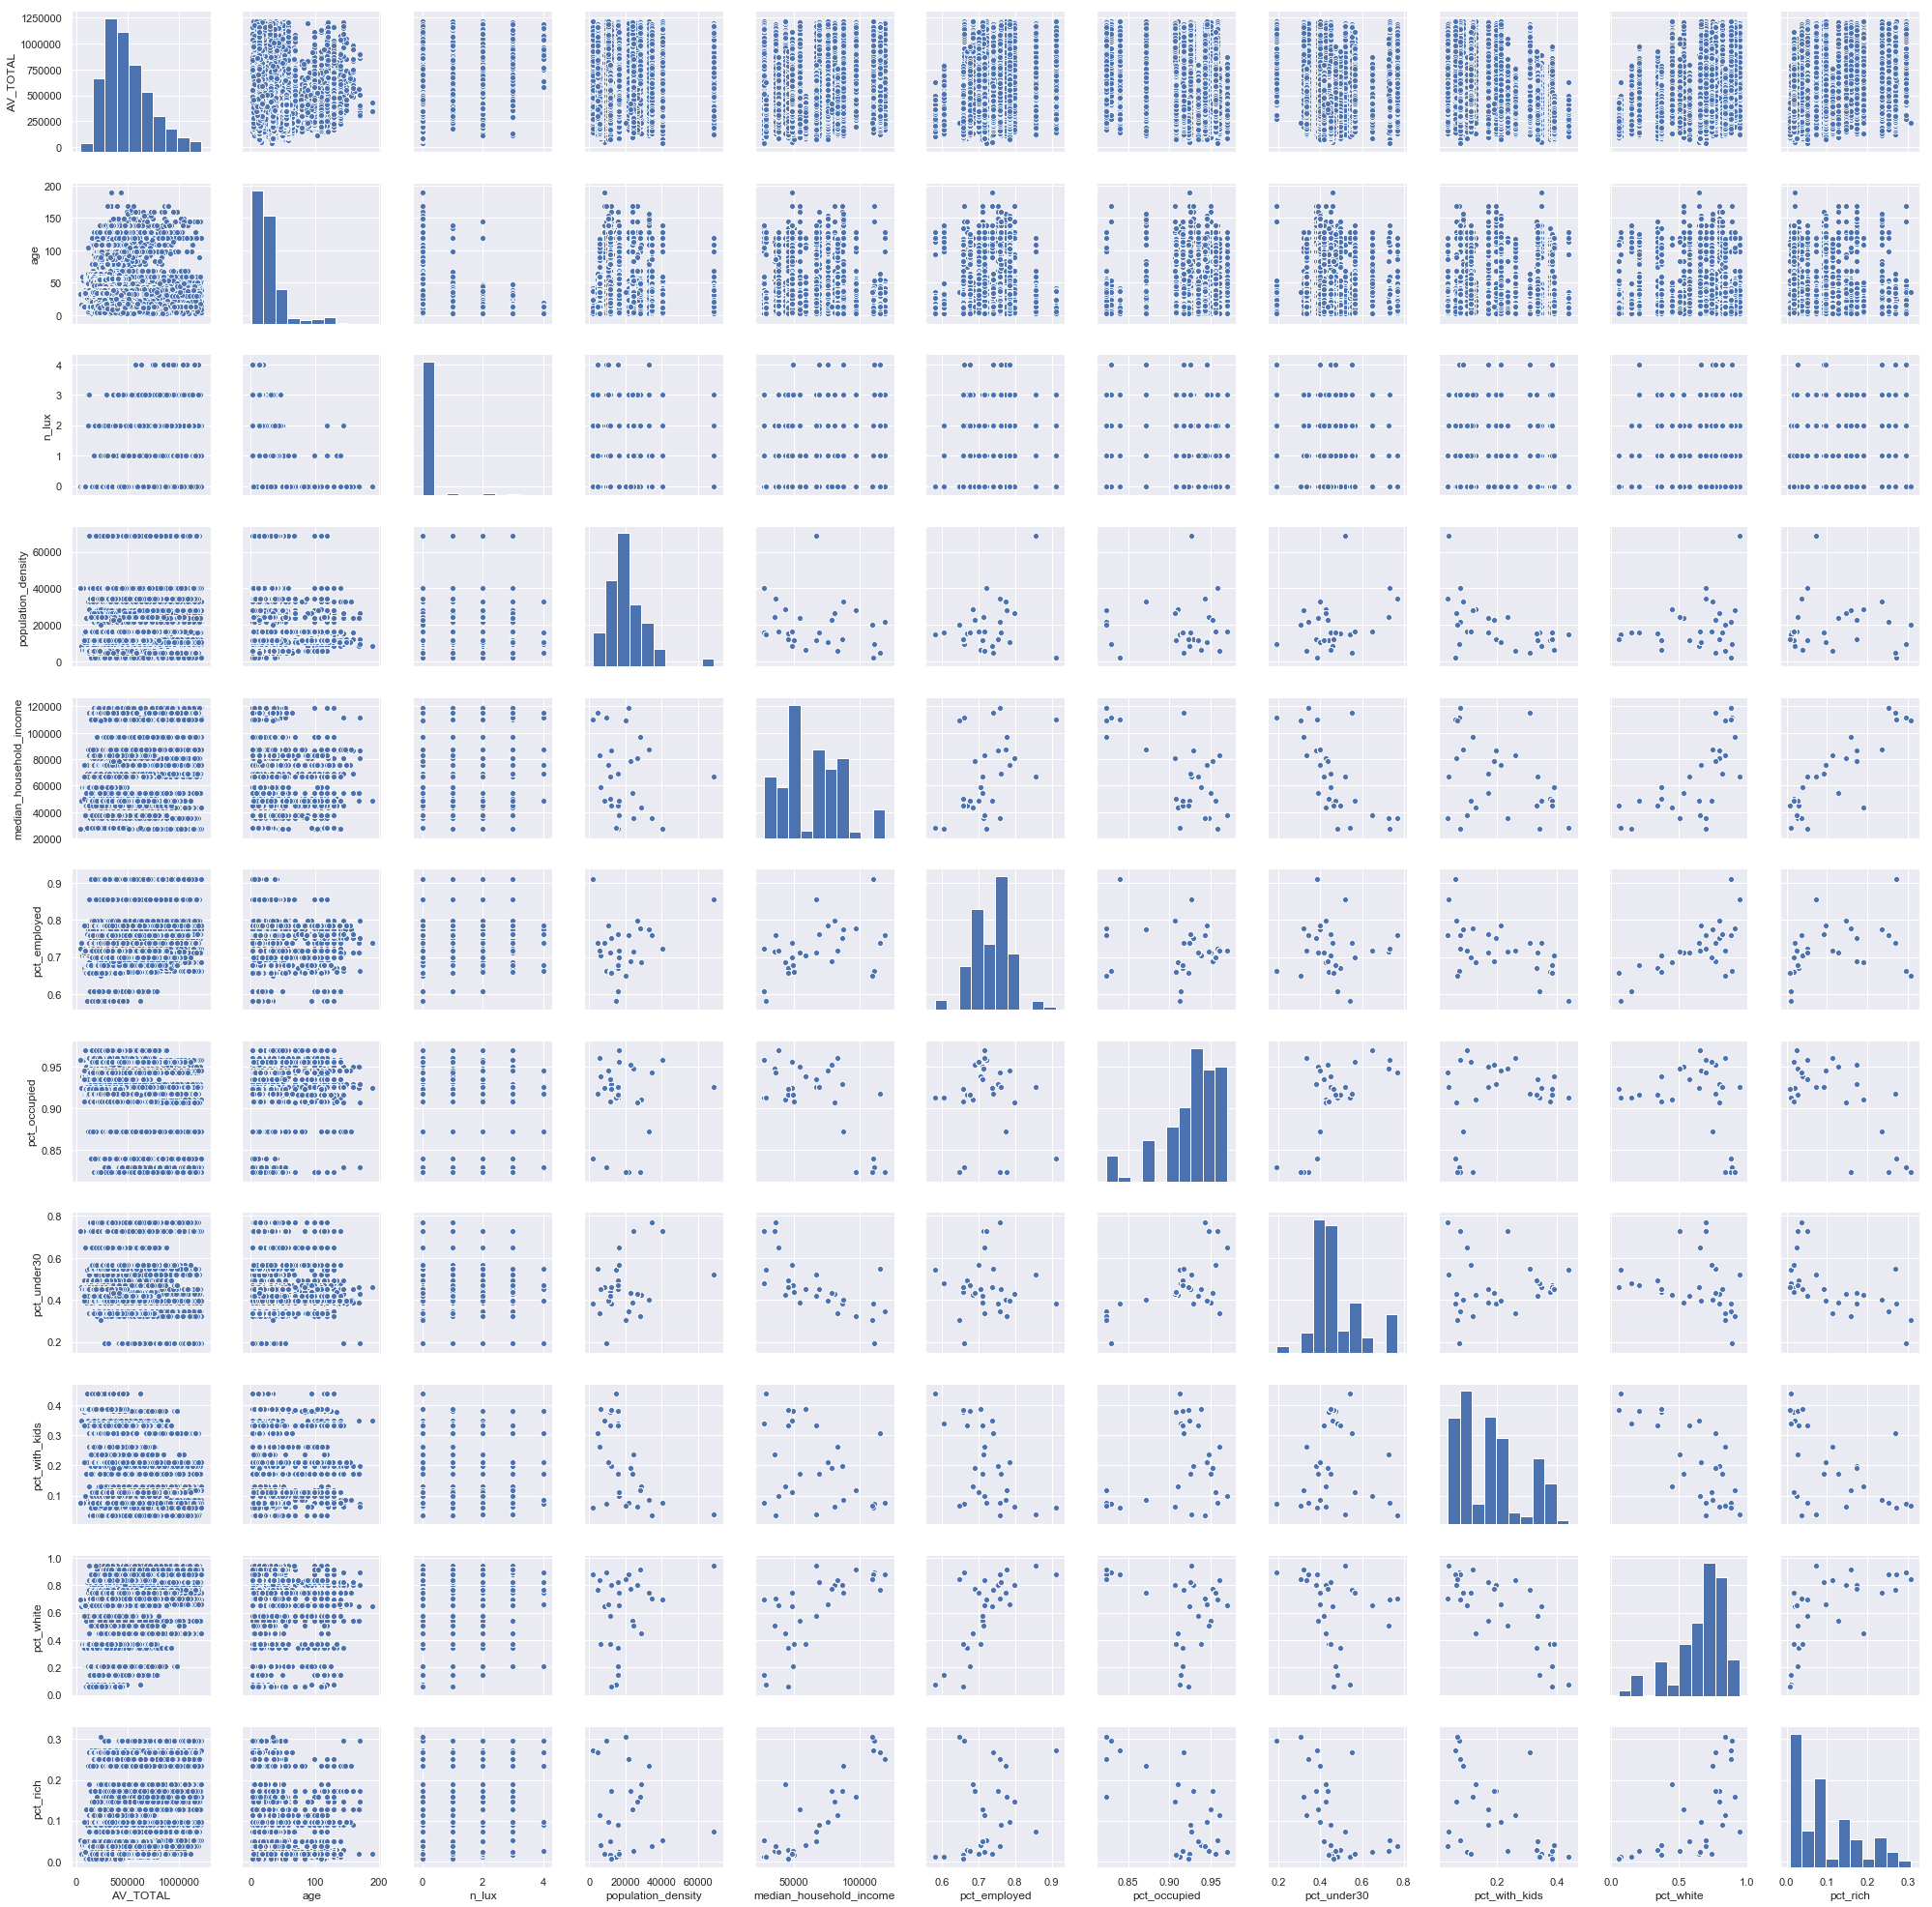

In [33]:
# pair plot of selected properties
sns.pairplot(contData[([targetCol] + ['age', 'n_lux',
              'population_density', 'median_household_income', 'pct_employed', 'pct_occupied',
              'pct_under30', 'pct_with_kids', 'pct_white', 'pct_rich'])])

In [31]:
# separate out target with aligned NaN removals
contTgt = contData[targetCol]
contData.drop(targetCol, axis=1, inplace=True)

In [114]:
# sklearn and related imports
# pre-processing
import sklearn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
# regressions
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
# classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC    # "Support vector classifier"
from sklearn.naive_bayes import GaussianNB
# cv/metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, scorer, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
# ignore data conversion warnings when fitting models
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Linear Regression Variants (including PCA)

In [99]:
# setting for training part used
trainPct = 0.25
nFolds = 5 # for cross-validation
# helper function to run and score model/pipeline
# should be agnostic to the nature of the model itself, which could be a pipeline
def run_model(model, df, y):
    # return a dictionary
    res = {}
    train_X, test_X, train_y, test_y = train_test_split(df, y, test_size=trainPct)
    model.fit(train_X, train_y)
    predictions = model.predict(test_X)
    # if these fields don't exist, just continue
    try:
        lr = model.named_steps['linearregression']
        res['coefs'] = lr.coef_
        res['intercept'] = lr.intercept_
        res['cv_r2'] = cross_val_score(lr, df, y, cv=nFolds, scoring='r2')
    except:
        pass        
    try:
        pca = model.named_steps['pca'] 
        res['pca_explained_pct'] = sum(pca.explained_variance_ratio_)
    except:
        pass        
    res['predictions'] = predictions
    res['score'] = model.score(test_X, test_y)
    # these only work for linear
    try:
        res['mae'] = mean_absolute_error(test_y, predictions)    
        res['rmse'] = mean_squared_error(test_y, predictions) ** (1/2)
        res['r2'] = r2_score(test_y, predictions)    
    except:
        pass
    try:
        res['is_accuracy_score'] = accuracy_score(y, model.predict(df))
        res['oos_accuracy_score'] = accuracy_score(test_y, predictions)
    except:
        pass
    return res
    

In [81]:
# run with and without standardization
# keep models in a dictionary
linMdl = {}
linMdl['unscaled_lr'] = LinearRegression(fit_intercept=True)
linMdl['unscaled_noIntercept_lr'] = LinearRegression(fit_intercept=False)
linMdl['std_lr'] = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=True))
linMdl['norm_lr'] = LinearRegression(fit_intercept=True, normalize=True)
# apply principal components
components_range = range(1, 11)
for ncomp in components_range:
    linMdl['std_pca{}_lr'.format(ncomp)] = make_pipeline(StandardScaler(), 
                                                         PCA(n_components=ncomp), 
                                                         LinearRegression(fit_intercept=True))
# look at polynomial regressions; square and cubic
poly_range = range(2, 4)
for pfc in poly_range: # iterate over polynomial feature count
    linMdl['std_poly{}_lr'.format(pfc)] = make_pipeline(StandardScaler(),
                                                        PolynomialFeatures(degree=pfc),
                                                        LinearRegression(fit_intercept=True))
    
# look at selecting best k features using f_regression
fcRng = range(2, 9)
for fc in fcRng:
    linMdl['std_kBest{}_lr'.format(fc)] = make_pipeline(StandardScaler(),
                                                        SelectKBest(f_regression, k=fc),
                                                        LinearRegression(fit_intercept=True))

In [82]:
# apply the model testing function above
linMdlRes = {}
for k, mdl in list(linMdl.items()):
    clear_output(wait=True)
    display('fitting {}'.format(k))
    linMdlRes[k] = run_model(mdl, contData, contTgt)    

'fitting std_kBest8_lr'

In [102]:
def model_result_df(mdlRes):
    # convert a dictionary of model results into a single dataframe with scalar properties
    copyCols = ['score', 'mae', 'rmse', 'r2']
    res = {}
    for k, md in mdlRes.items():        
        mres = {}
        for cc in copyCols:
            try:
                mres[cc] = md[cc]
            except:
                continue
        # not all models will have done cross-validation
        try:
            mres['n_coeff'] = md['coefs'].size
            mres['cv_mean_r2'] = md['cv_r2'].mean()
            mres['cv_std_r2'] = md['cv_r2'].std()        
        except:
            pass
        try:
            mres['pca_variance_ratio'] = md['pca_explained_pct']
        except:
            pass
        try:
            mres['accuracy_score'] = md['accuracy_score']
        except:
            pass
        res[k] = mres
    df = pd.DataFrame.from_dict(res, orient='index')
    return df


In [83]:
linMdlDf = model_result_df(linMdlRes)
display(linMdlDf)

,score,mae,rmse,r2,n_coeff,cv_mean_r2,cv_std_r2,pca_variance_ratio
norm_lr,0.709263,87705.017507,123645.908655,0.709263,NaN,NaN,NaN,NaN
std_kBest2_lr,0.249735,153101.003096,198613.176221,0.249735,2.0,0.253639,0.333506,NaN
std_kBest3_lr,0.294656,151352.612292,194742.707407,0.294656,3.0,0.253639,0.333506,NaN
std_kBest4_lr,0.565507,111155.975012,151461.284528,0.565507,4.0,0.253639,0.333506,NaN
std_kBest5_lr,0.618651,106350.603867,142465.113350,0.618651,5.0,0.253639,0.333506,NaN
std_kBest6_lr,0.615468,101982.744008,141101.887765,0.615468,6.0,0.253639,0.333506,NaN
std_kBest7_lr,0.611311,103379.725219,143095.452487,0.611311,7.0,0.253639,0.333506,NaN
std_kBest8_lr,0.619146,103109.731467,142510.427758,0.619146,8.0,0.253639,0.333506,NaN
std_lr,0.710399,87990.633908,123558.377677,0.710399,20.0,0.253639,0.333506,NaN
std_pca10_lr,0.593773,106997.531935,145940.320869,0.593773,10.0,0.253639,0.333506,0.928929


Based on the results above, applying standard scaling to the linear regression model with the full set of features included does not meaningfully improve performance. None of these results look particularly good, however.

As you increase the number of principal components, the r2 performance begins to converge towards the full set of predictors.

The cubic polynomial regression performed best of the models attempted here.

# Classification
For the classification algorithms, we will attempt to predict whether a condo unit is owner-occupied.

In [86]:
# TODO: separate runner function for classification problems
# predict whether a house is owner-occupied; it's a binary problem but you can still use SVM etc.
targetCol = 'OWN_OCC'
# create copy of pred for use in regressions, w/ only continuous
contData = pred[regCont + [targetCol]].dropna(how='any').copy()
# separate out target with aligned NaN removals
contTgt = contData[targetCol]
contData.drop(targetCol, axis=1, inplace=True)


In [115]:
clsMdls = {}
# logistic regression variants
clsMdls['raw_logistic'] = LogisticRegression(solver='lbfgs')
clsMdls['std_logistic'] = make_pipeline(StandardScaler(), 
                                        LogisticRegression(solver='lbfgs'))
clsMdls['raw_mult_logistic'] = LogisticRegression(solver='lbfgs', multi_class='multinomial')
clsMdls['std_mult_logistic'] = make_pipeline(StandardScaler(),
                                             LogisticRegression(solver='lbfgs', multi_class='multinomial'))
clsMdls['raw_decision_tree'] = DecisionTreeClassifier()
clsMdls['std_decision_tree'] = make_pipeline(StandardScaler(),
                                            DecisionTreeClassifier())
clsMdls['raw_linear_svm'] = SVC(kernel='linear')
clsMdls['raw_NB'] = GaussianNB()

In [ ]:
clsMdlRes = {}
for k, mdl in list(clsMdls.items()):
    clear_output(wait=True)
    display('fitting {}'.format(k))
    clsMdlRes[k] = run_model(mdl, contData, contTgt)

'fitting raw_linear_svm'

In [112]:
clsMdlDf = model_result_df(clsMdlRes)
display(clsMdlDf)

,score
raw_decision_tree,0.603884
raw_logistic,0.642236
raw_mult_logistic,0.642793
std_decision_tree,0.608687
std_logistic,0.668476
std_mult_logistic,0.664579


# Clustering
For clustering analysis, we will look at identifying similarities between Boston zip codes. 

In [ ]:
# review zipcode data
zipData.head()